In [2]:
#import libarary
import time
import pickle
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
from keras.layers import Embedding, LSTM, Dropout, Dense
from keras.models import Sequential
import seaborn as sns
import matplotlib.pyplot as plt
import gradio as gr

/home/shailesh/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Constants
SEQUENCE_LENGTH = 100
EMBEDDING_SIZE = 100
TEST_SIZE = 0.25
BATCH_SIZE = 64
EPOCHS = 10

label2int = {"ham": 0, "spam": 1}
int2label = {0: "ham", 1: "spam"}

In [4]:
# Load data
def load_data():
    texts, labels = [], []
    with open("/home/shailesh/data/SMSSpamCollection") as f:
        for line in f:
            split = line.split()
            labels.append(split[0].strip())
            texts.append(' '.join(split[1:]).strip())
    return texts, labels

X, y = load_data()

In [5]:
# Tokenize and preprocess text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
pickle.dump(tokenizer, open("/home/shailesh/results/tokenizer.pickle", "wb"))

X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=SEQUENCE_LENGTH)

y = [label2int[label] for label in y]
y = to_categorical(y)

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=7)

In [7]:
# Define the model architecture
def get_model(tokenizer, lstm_units):
    vocab_size = len(tokenizer.word_index) + 1
    model = Sequential()
    model.add(Embedding(vocab_size, EMBEDDING_SIZE, input_length=SEQUENCE_LENGTH))
    model.add(LSTM(lstm_units, recurrent_dropout=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(2, activation="softmax"))
    model.compile(optimizer="rmsprop", loss="categorical_crossentropy",
                  metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    model.summary()
    return model

model = get_model(tokenizer, lstm_units=128)

2023-05-19 15:14:48.949901: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-19 15:14:48.997554: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          901300    
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 1,018,806
Trainable params: 1,018,806
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Train the model
model_checkpoint = ModelCheckpoint("/home/shailesh/results/spam_classifier_{val_loss:.2f}.h5", save_best_only=True, verbose=1)
tensorboard = TensorBoard(f"/home/shailesh/logs/spam_classifier_{time.time()}")

history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    batch_size=BATCH_SIZE, epochs=EPOCHS,
                    callbacks=[tensorboard, model_checkpoint],
                    verbose=1)


Epoch 1/10
66/66 [==============================] - ETA: 0s - loss: 0.2222 - accuracy: 0.9215 - precision: 0.9215 - recall: 0.9215
Epoch 1: val_loss improved from inf to 0.10177, saving model to /home/shailesh/results/spam_classifier_0.10.h5
66/66 [==============================] - 9s 106ms/step - loss: 0.2222 - accuracy: 0.9215 - precision: 0.9215 - recall: 0.9215 - val_loss: 0.1018 - val_accuracy: 0.9684 - val_precision: 0.9684 - val_recall: 0.9684
Epoch 2/10
66/66 [==============================] - ETA: 0s - loss: 0.0585 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845
Epoch 2: val_loss improved from 0.10177 to 0.07205, saving model to /home/shailesh/results/spam_classifier_0.07.h5
66/66 [==============================] - 7s 104ms/step - loss: 0.0585 - accuracy: 0.9845 - precision: 0.9845 - recall: 0.9845 - val_loss: 0.0720 - val_accuracy: 0.9857 - val_precision: 0.9857 - val_recall: 0.9857
Epoch 3/10
66/66 [==============================] - ETA: 0s - loss: 0.0367 - accuracy:

In [9]:
# Evaluate the model
result = model.evaluate(X_test, y_test)
loss = result[0]
accuracy = result[1]
precision = result[2]
recall = result[3]

print(f"[+] Accuracy: {accuracy * 100:.2f}%")
print(f"[+] Precision: {precision * 100:.2f}%")
print(f"[+] Recall: {recall * 100:.2f}%")

44/44 [==============================] - 1s 18ms/step - loss: 0.0453 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878
[+] Accuracy: 98.78%
[+] Precision: 98.78%
[+] Recall: 98.78%


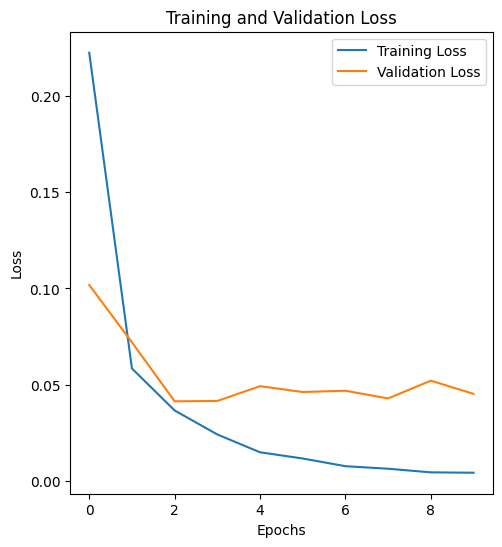

In [10]:
# Visualize the training process
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

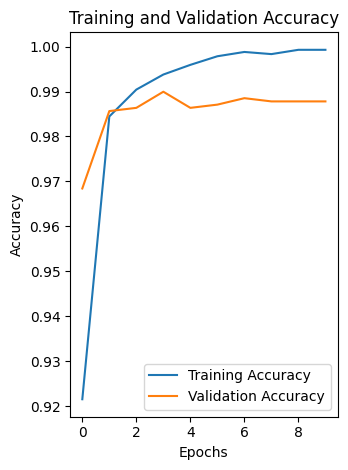

In [11]:
#more visualize
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# Define the function for email classification
def get_predictions(text):
    sequence = tokenizer.texts_to_sequences([text])
    sequence = pad_sequences(sequence, maxlen=SEQUENCE_LENGTH)
    prediction = model.predict(sequence)[0]
    return int2label[prediction.argmax()]

def classify_email(text):
    prediction = get_predictions(text)
    return f"The email is {prediction}"

In [13]:
# Create and launch the Gradio interface
app = gr.Interface(fn=classify_email, inputs="text", outputs="text")
app.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
